# Identification of human sequences

We'll try to replicate the [Classifying human DNA sequence and random ATCG sequences, using keras CNN](https://github.com/onceupon/deep_learning_DNA) problem, but using PyTorch instead.

In [1]:
import torch
from torch import nn
import pandas as pd
import os

In [2]:
dataset = pd.read_csv("datasets/testing/human-exercise.csv")
print(dataset.shape)
dataset

(20000, 2)


,sequence,label
0,CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCA...,1
1,CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACA...,1
2,AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGC...,1
3,AAGTGGATATTCAGACCTCCTTGAGGCCTTCGTTGGAAACGGGATT...,1
4,ATACCATGACAAAGATATTATTAGCCAATTTTTAGAGAGAAGGAAA...,1
...,...,...
19995,AAGACGAGTGGTTACCCCCTGTGAGACTGCCGCGCGTGGTGGTCGG...,0
19996,ACGAGGCCATCTAGAGCGCAACGAAACTGCAAGAAAATACGTCCGA...,0
19997,CATCTTTACCCAATTTGTGTGTGGAAAGGTGTCAGCGATGCTTTGG...,0
19998,ATAAGTAACTCCAGTCGAGCGGAAGGTATAGTGGCACGGGGTTTAG...,0


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the human DNA. The amount of positive and negative examples is evenly distributed across the two classes.

1    10000
0    10000
Name: label, dtype: int64


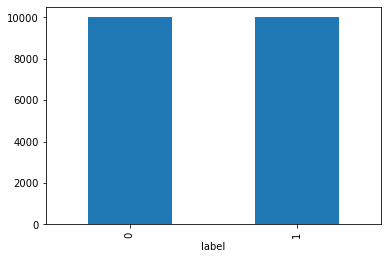

In [3]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

print(dataset['label'].value_counts())

We need now to split the dataset into training, test and validation sets.

In [4]:
fps_x = dataset['sequence'].values
fps_y = dataset['label'].values

In [5]:
# save fps_x and fps_y to pickle file
import pickle
with open("datasets/primer/fps_x.pkl", "wb") as f:
    pickle.dump(fps_x, f)
with open("datasets/primer/fps_y.pkl", "wb") as f:
    pickle.dump(fps_y, f)

Building the model equivalent to the one in the paper.

In [6]:
%load_ext autoreload
%autoreload 2
from src.hyperparameter_tuning import hyperparameter_tuning
from ray import tune

In [7]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class_weights = torch.tensor([1.0, 1.0]).to(device)

fixed_vals = {
    'epochs': 50,
    'optimizer_label': 'adam',
    'loss_function': nn.CrossEntropyLoss(weight=class_weights),
    'patience': 2, 
    'output_size': 2,     
    'model_label': 'net',
    'data_dir': 'testing',
    'mode': 'one_hot'
}

config = {
    "hidden_size": tune.choice([32, 64, 128, 256]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32]),
    "dropout": tune.uniform(0.3, 0.5)
}

In [8]:
hyperparameter_tuning(device, fixed_vals, config)

/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)
2022-06-20 15:02:53,951	WARNING experiment.py:295 -- No name detected on trainable. Using DEFAULT.
2022-06-20 15:02:53,952	INFO registry.py:66 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 74.2/754.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/80 CPUs, 2.0/2 GPUs, 0.0/495.36 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06-20_15-02-53
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+-----------+---------------+-------------+
| Trial name          | status   | loc   |   batch_size |   dropout |   hidden_size |          lr |
|---------------------+----------+-------+--------------+-----------+---------------+-------------|
| DEFAULT_adf6a_00000 | RUNNING  |       |           16 |  0.311794 |           128 | 0.0480111   |
| DEFAULT_adf6a_00001 | PENDING  |       |            8 |  0.352271 |            32 | 0.00436203  |
| DEFAULT_adf6a_00002 | PENDING  |       |         

2022-06-20 15:10:52,227	INFO tune.py:561 -- Total run time: 478.28 seconds (478.01 seconds for the tuning loop).


Result for DEFAULT_adf6a_00014:
  accuracy: 0.98425
  date: 2022-06-20_15-10-52
  done: true
  experiment_id: 37a0d50cdd4f4624a3620f9cebbe4479
  hostname: turing
  iterations_since_restore: 2
  loss: 0.37393640887737273
  mcc: 0.9685146488948476
  node_ip: 192.168.85.234
  pid: 1509467
  should_checkpoint: true
  time_since_restore: 9.36946415901184
  time_this_iter_s: 1.9897551536560059
  time_total_s: 9.36946415901184
  timestamp: 1655734252
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: adf6a_00014
  
== Status ==
Memory usage on this node: 53.7/754.3 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 32.000: None | Iter 16.000: -0.813261736869812 | Iter 8.000: -0.3537717391252517 | Iter 4.000: -0.33308690738677976 | Iter 2.000: -0.34285104322433474 | Iter 1.000: -0.5286276074647903
Resources requested: 0/80 CPUs, 0/2 GPUs, 0.0/495.36 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06-20_15-02-53